In [1]:
import numpy as np
from scipy.integrate import quad, simps
from scipy.interpolate import interp2d
import matplotlib.pyplot as plt
import pyccl as ccl
from pyccl.halos import HaloProfile
from pyccl import rho_x

In [2]:
class HaloProfilePressureBattaglia(HaloProfile):
    def __init__(self, alpha=1, gamma=-0.3,
                 P0_A=18.1, P0_aM=0.154, P0_az=-0.758,
                 xc_A=0.497, xc_aM=-0.00865, xc_az=0.731,
                 beta_A=4.35, beta_aM=0.0393, beta_az=0.415,
                 beta_interp_spacing=0.3,
                 qrange=(1e-3, 1e3), nq=128, x_out=np.inf):
        self.alpha = alpha
        self.gamma = gamma
        self.P0_A = P0_A
        self.P0_aM = P0_aM
        self.P0_az = P0_az
        self.xc_A = xc_A
        self.xc_aM = xc_aM
        self.xc_az = xc_az
        self.beta_A = beta_A
        self.beta_aM = beta_aM
        self.beta_az = beta_az

        self.beta_interp_spacing = beta_interp_spacing
        self.qrange = qrange
        self.nq = nq
        self.x_out = x_out
        self._fourier_interp = None
        super(HaloProfilePressureBattaglia, self).__init__()

    def _AMz(self, M, a, A, aM, az):
        return A*(M*1E-14)**aM/a**az

    def _beta(self, M, a):
        return self._AMz(M, a, self.beta_A,
                         self.beta_aM, self.beta_az)

    def _xc(self, M, a):
        return self._AMz(M, a, self.xc_A,
                         self.xc_aM, self.xc_az)

    def _P0(self, M, a):
        return self._AMz(M, a, self.P0_A,
                         self.P0_aM, self.P0_az)

    def update_parameters(self, alpha=None, gamma=None,
                          P0_A=None, P0_aM=None, P0_az=None,
                          xc_A=None, xc_aM=None, xc_az=None,
                          beta_A=None, beta_aM=None, beta_az=None):
        if P0_A is not None:
            self.P0_A = P0_A
        if P0_aM is not None:
            self.P0_aM = P0_aM
        if P0_az is not None:
            self.P0_az = P0_az
        if xc_A is not None:
            self.xc_A = xc_A
        if xc_aM is not None:
            self.xc_aM = xc_aM
        if xc_az is not None:
            self.xc_az = xc_az
        if beta_A is not None:
            self.beta_A = beta_A
        if beta_aM is not None:
            self.beta_aM = beta_aM
        if beta_az is not None:
            self.beta_az = beta_az

        re_fourier = False
        if alpha is not None:
            if alpha != self.alpha:
                re_fourier = True
            self.alpha = alpha
        if gamma is not None:
            if gamma != self.gamma:
                re_fourier = True
            self.gamma = gamma

        if re_fourier and (self._fourier_interp is not None):
            self._fourier_interp = self._integ_interp()

    def _form_factor(self, x, beta):
        return x**self.gamma/(1+x**self.alpha)**beta

    def _integ_interp(self):
        qs = np.geomspace(self.qrange[0], self.qrange[1], self.nq+1)

        def integrand(x, beta):
            return self._form_factor(x, beta)*x

        beta0 = self._beta(1E10, 1.)-1
        beta1 = self._beta(1E15, 1/(1+6.))+1
        nbeta = int((beta1-beta0)/self.beta_interp_spacing)
        betas = np.linspace(beta0, beta1, nbeta)
        f_arr = np.array([[quad(integrand, args=(beta,),
                                a=1e-4, b=self.x_out,  # limits of integration
                                weight="sin",  # fourier sine weight
                                wvar=q)[0] / q
                           for q in qs] for beta in betas])
        # Set to zero at high q, so extrapolation does the right thing.
        f_arr[:, -1] = 1E-100
        Fqb = interp2d(np.log(qs), betas, np.log(f_arr),
                       fill_value=None, kind='cubic',
                       bounds_error=False)
        return Fqb

    def _norm(self, cosmo, M, a, mass_def):
        # Electron fraction = (5XH+3)/(2*(XH+1)) = 1.932 with
        # XH = 0.76 the hydrogen fraction
        fe = 1.9318
        fb = cosmo['Omega_b']/(cosmo['Omega_c']+cosmo['Omega_b'])
        RM = mass_def.get_radius(cosmo, M, a)
        Delta = mass_def.get_Delta(cosmo, a)
        # G in units of eV*(Mpc^4)/(cm^3*Msun^2)
        G = 1.81805235E-27
        # Density in Msun/Mpc^3
        rho = rho_x(cosmo, a, mass_def.rho_type)
        P0 = self._P0(M, a)
        return P0*fb*G*M*Delta*rho/(2*RM*fe)

    def _fourier(self, cosmo, k, M, a, mass_def):
        if self._fourier_interp is None:
            self._fourier_interp = self._integ_interp()

        # Input handling
        M_use = np.atleast_1d(M)
        k_use = np.atleast_1d(k)

        xc = self._xc(M_use, a)
        # R_Delta*(1+z)
        xrDelta = xc*mass_def.get_radius(cosmo, M_use, a) / a

        qs = k_use[None, :]*xrDelta[:, None]
        betas = self._beta(M_use, a)
        ff = np.array([self._fourier_interp(np.log(q), beta)
                       for q, beta in zip(qs, betas)])
        ff = np.exp(ff)
        nn = self._norm(cosmo, M_use, a, mass_def)

        prof = (4*np.pi*xrDelta**3 * nn)[:, None] * ff

        if np.ndim(k) == 0:
            prof = np.squeeze(prof, axis=-1)
        if np.ndim(M) == 0:
            prof = np.squeeze(prof, axis=0)
        return prof

    def _real(self, cosmo, r, M, a, mass_def):
        # Real-space profile.
        # Output in units of eV/cm^3
        r_use = np.atleast_1d(r)
        M_use = np.atleast_1d(M)

        xc = self._xc(M_use, a)
        xrDelta = xc*mass_def.get_radius(cosmo, M_use, a) / a
        betas = self._beta(M_use, a)

        nn = self._norm(cosmo, M_use, a, mass_def)
        prof = self._form_factor(r_use[None, :] / xrDelta[:, None], betas[:, None])
        prof *= nn[:, None]

        if np.ndim(r) == 0:
            prof = np.squeeze(prof, axis=-1)
        if np.ndim(M) == 0:
            prof = np.squeeze(prof, axis=0)
        return prof

    def profile_cumul_nr(self, nr, cosmo, M, a, mass_def):
        M_use = np.atleast_1d(M)
        rDelta = mass_def.get_radius(cosmo, M, a)/a
        rmax = nr*rDelta
        rs = np.geomspace(1E-3, rmax, 256).T
        pr = np.array([self._real(cosmo, r, m, a, mass_def)
                       for r, m in zip(rs, M_use)])
        cprof = simps(pr*rs**3, x=np.log(rs), axis=-1)*4*np.pi
        if np.ndim(M) == 0:
            cprof = np.squeeze(cprof, axis=0)
        return cprof

In [3]:
cosmo = ccl.Cosmology(Omega_c=0.26066676,
                      Omega_b=0.048974682,
                      h=0.6766,
                      n_s=0.9665,
                      sigma8=0.8102)

In [4]:
mfc = ccl.halos.mass_function_from_name('Tinker08')
hbc = ccl.halos.halo_bias_from_name('Tinker10')
prof1 = ccl.halos.HaloProfilePressureGNFW(mass_bias=0.75)
massdef1 = ccl.halos.MassDef(500, 'critical')
mf1 = mfc(cosmo, mass_def=massdef1)
hb1 = hbc(cosmo, mass_def=massdef1)
hmc1 = ccl.halos.HMCalculator(cosmo, mf1, hb1, massdef1)

massdef2 = ccl.halos.MassDef(200, 'critical')
cM = ccl.halos.ConcentrationDuffy08(mdef=massdef2)
prof2 = HaloProfilePressureBattaglia()
profM = ccl.halos.HaloProfileNFW(cM)
mf2 = mfc(cosmo, mass_def=massdef2)
hb2 = hbc(cosmo, mass_def=massdef2)
hmc2 = ccl.halos.HMCalculator(cosmo, mf2, hb2, massdef2)

In [5]:
def get_bpe_battaglia(cosmo, hmc, a, prof, nr):
    hmc._get_ingredients(a, cosmo, True)
    cprof = prof.profile_cumul_nr(nr, cosmo, hmc._mass, a, hmc._mdef)
    return hmc._integrate_over_mbf(cprof)

def get_Omth_battaglia(cosmo, hmc, a, prof, nr):
    hmc._get_ingredients(a, cosmo, False)
    cprof = prof.profile_cumul_nr(nr, cosmo, hmc._mass, a, hmc._mdef)
    pe = hmc._integrate_over_mf(cprof)
    Y = 0.24
    prefac = (8-5*Y)/(4-2*Y)
    rho_th = pe*prefac*a**3
    # rho_critical in eV/cm^3
    rho_crit = 10537.0711*cosmo['h']**2
    return rho_th/rho_crit

def get_Omgrav(cosmo, hmc, zs, prof):
    ks = np.geomspace(1E-4, 100, 256)
    pk = ccl.halos.halomod_power_spectrum(cosmo, hmc, ks, 1/(1+zs), prof,
                                          normprof1=True, get_1h=True,
                                          get_2h=False)
    pkint = simps(ks*pk, x=np.log(ks), axis=-1)
    Omega_m = cosmo['Omega_c']+cosmo['Omega_b']
    return 3*Omega_m*cosmo['Omega_b']*cosmo['h']**2*1.11265006E-7*pkint*(1+zs)/(16*np.pi**2)

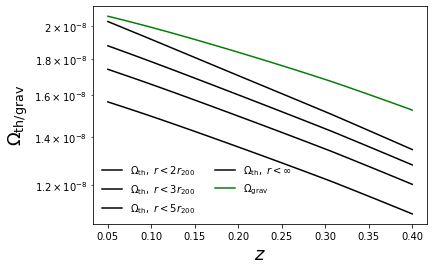

In [6]:
zs = np.linspace(0.05, 0.4, 64)
Omth_2 = np.array([get_Omth_battaglia(cosmo, hmc2, 1./(1+z), prof2, 2) for z in zs])
Omth_3 = np.array([get_Omth_battaglia(cosmo, hmc2, 1./(1+z), prof2, 3) for z in zs])
Omth_5 = np.array([get_Omth_battaglia(cosmo, hmc2, 1./(1+z), prof2, 5) for z in zs])
Omth_inf = np.array([get_Omth_battaglia(cosmo, hmc2, 1./(1+z), prof2, 100) for z in zs])
Omgr = get_Omgrav(cosmo, hmc2, zs, profM)

plt.plot(zs, Omth_2, 'k-', label=r'$\Omega_{\rm th},\,\, r<2r_{200}$')
plt.plot(zs, Omth_3, 'k-', label=r'$\Omega_{\rm th},\,\, r<3r_{200}$')
plt.plot(zs, Omth_5, 'k-', label=r'$\Omega_{\rm th},\,\, r<5r_{200}$')
plt.plot(zs, Omth_inf, 'k-', label=r'$\Omega_{\rm th},\,\, r<\infty$')
plt.plot(zs, Omgr, 'g-', label=r'$\Omega_{\rm grav}$')
plt.yscale('log')
plt.ylabel(r'$\Omega_{\rm th/grav}$', fontsize=18)
plt.xlabel(r'$z$', fontsize=18)
plt.legend(loc='lower left', ncol=2, frameon=False);

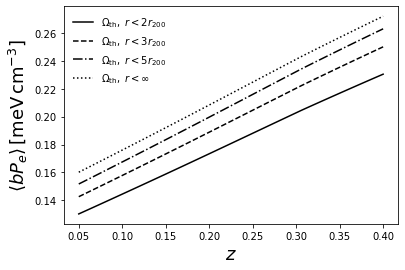

In [7]:
zs = np.linspace(0.05, 0.4, 64)
bpe_2 = np.array([get_bpe_battaglia(cosmo, hmc2, 1./(1+z), prof2, 2) for z in zs])*1E3
bpe_3 = np.array([get_bpe_battaglia(cosmo, hmc2, 1./(1+z), prof2, 3) for z in zs])*1E3
bpe_5 = np.array([get_bpe_battaglia(cosmo, hmc2, 1./(1+z), prof2, 5) for z in zs])*1E3
bpe_inf = np.array([get_bpe_battaglia(cosmo, hmc2, 1./(1+z), prof2, 100) for z in zs])*1E3
plt.plot(zs, bpe_2, 'k-', label=r'$\Omega_{\rm th},\,\, r<2r_{200}$')
plt.plot(zs, bpe_3, 'k--', label=r'$\Omega_{\rm th},\,\, r<3r_{200}$')
plt.plot(zs, bpe_5, 'k-.', label=r'$\Omega_{\rm th},\,\, r<5r_{200}$')
plt.plot(zs, bpe_inf, 'k:', label=r'$\Omega_{\rm th},\,\, r<\infty$')
plt.ylabel(r'$\langle bP_e\rangle\,[{\rm meV}\,{\rm cm}^{-3}]$', fontsize=18)
plt.xlabel(r'$z$', fontsize=18)
plt.legend(loc='upper left', ncol=1, frameon=False);